In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, combinations
import time
from math import inf
import math

In [4]:
########## network tier and devices information


### Config1
tier_number = 4
J = list(range(1, tier_number+1))
prop = [10, 50, 50]
bw = [1000, 100000, 1000000]
comp_ratio = {1:100, 2:20, 3:10, 4:1}



# ### Config2
# tier_number = 3
# J = list(range(1, tier_number+1))
# prop = [50, 50]
# bw = [54000, 54000]
# comp_ratio = {2:20, 3:10, 4:1}




# ### Config3
# tier_number = 4
# J = list(range(1, tier_number+1))
# prop = [10, 20, 60]
# bw = [54000, 54000, 500000]
# comp_ratio = {1:10, 2:5, 3:2, 4:1}

In [5]:
### ResNet20 + CIFAR10 information

### all possible branches
branch_number = 10
I = list(range(1, branch_number+1))
sample_number = 50000

### result size
class_number = 10
result_size = math.ceil(math.log2(class_number))

### input and intermediate data size
input_size = 32*32*3*32
out_size = {1:32*32*16*32, 2:32*32*16*32, 3:32*32*16*32, 4:32*32*16*32, 5:16*16*32*32, 6:16*16*32*32, 7:16*16*32*32, 8:8*8*64*32, 9:8*8*64*32, 10:8*8*64*32}

### accuracy of all exit branches
acc = {1:0.3992, 2:0.5918 , 3:0.6510, 4:0.6742, 5:0.7652, 6:0.8232, 7:0.8432, 8:0.8660, 9: 0.8790, 10:0.8848} 

# ### average exit rate of all exit branches. the sum is always 1.
# alpha = dict(zip(I, [0.391538, 0.213815, 0.081094, 0.035173, 0.078104, 0.053637, 0.021061, 0.020858,
#  0.014318, 0.090402]))

### backbone and exit branch computation latency seperately
comp_backbone = dict(zip(I, [1.07619735, 1.57224027, 1.43387813, 1.37183341, 1.66043956, 1.34008288,
 1.33225136, 1.60562826, 1.30284467, 1.29567097]))

comp_exitbranch = dict(zip(I, [0.54828413, 0.56144403, 0.56343376, 0.54711585, 0.54355211, 0.53792531,
 0.53540504, 0.53916863, 0.53609725, 0.53421628]))


def add_alpha_plus_list(dic):
    dic.update((x, y/sample_number) for x, y in dic.items())
    alpha_plus = {1: dic.get(1)} if dic.get(1) is not None else {1: 0}
    for i in range (1,len(I)):
        curr = dic.get(i+1) if dic.get(i+1) is not None else 0
        alpha_plus[i+1] = curr + alpha_plus.get(i)
        
    alpha_plus.update((x, round(y, 4)) for x, y in alpha_plus.items())
    print(alpha_plus)
    return alpha_plus



threshold_list = np.linspace(0.000000001, 0.999999999, num=20)

alpha_plus_list = []
alpha_plus_list.append(add_alpha_plus_list({6: 14, 7: 23, 8: 40, 9: 123, 10: 49800}))
alpha_plus_list.append(add_alpha_plus_list({1: 802, 2: 3435, 3: 4150, 4: 2270, 5: 7682, 6: 7863, 7: 3649, 8: 4254, 9: 3258, 10: 12637}))
alpha_plus_list.append(add_alpha_plus_list({1: 1479, 2: 5763, 3: 5648, 4: 2715, 5: 8320, 6: 7636, 7: 3325, 8: 3619, 9: 2731, 10: 8764}))
alpha_plus_list.append(add_alpha_plus_list({1: 2167, 2: 8004, 3: 6311, 4: 3064, 5: 8572, 6: 7129, 7: 2978, 8: 3130, 9: 2259, 10: 6386}))
alpha_plus_list.append(add_alpha_plus_list({1: 2829, 2: 10225, 3: 6822, 4: 3282, 5: 8608, 6: 6468, 7: 2674, 8: 2688, 9: 1806, 10: 4598}))
alpha_plus_list.append(add_alpha_plus_list({1: 3618, 2: 12477, 3: 7215, 4: 3481, 5: 8299, 6: 5794, 7: 2328, 8: 2141, 9: 1386, 10: 3261}))
alpha_plus_list.append(add_alpha_plus_list({1: 4859, 2: 15021, 3: 7301, 4: 3399, 5: 7732, 6: 5053, 7: 1880, 8: 1631, 9: 1045, 10: 2079}))
alpha_plus_list.append(add_alpha_plus_list({1: 6685, 2: 16695, 3: 7441, 4: 3320, 5: 6991, 6: 4132, 7: 1472, 8: 1257, 9: 684, 10: 1323}))
alpha_plus_list.append(add_alpha_plus_list({1: 8944, 2: 18078, 3: 7255, 4: 3066, 5: 6128, 6: 3266, 7: 1083, 8: 925, 9: 466, 10: 789}))
alpha_plus_list.append(add_alpha_plus_list({1: 11666, 2: 19041, 3: 6831, 4: 2869, 5: 5109, 6: 2436, 7: 763, 8: 591, 9: 279, 10: 415}))
alpha_plus_list.append(add_alpha_plus_list({1: 15020, 2: 19423, 3: 6176, 4: 2457, 5: 4005, 6: 1731, 7: 480, 8: 334, 9: 159, 10: 215}))
alpha_plus_list.append(add_alpha_plus_list({1: 19054, 2: 19049, 3: 5203, 4: 2002, 5: 2994, 6: 1116, 7: 257, 8: 160, 9: 76, 10: 89}))
alpha_plus_list.append(add_alpha_plus_list({1: 23560, 2: 17915, 3: 4198, 4: 1505, 5: 1974, 6: 612, 7: 101, 8: 65, 9: 34, 10: 36}))
alpha_plus_list.append(add_alpha_plus_list({1: 28508, 2: 16031, 3: 3108, 4: 962, 5: 1044, 6: 267, 7: 42, 8: 19, 9: 10, 10: 9}))
alpha_plus_list.append(add_alpha_plus_list({1: 33617, 2: 13337, 3: 1967, 4: 520, 5: 453, 6: 93, 7: 6, 8: 4, 9: 2, 10: 1}))
alpha_plus_list.append(add_alpha_plus_list({1: 38767, 2: 9821, 3: 1017, 4: 204, 5: 164, 6: 27}))
alpha_plus_list.append(add_alpha_plus_list({1: 43439, 2: 6083, 3: 394, 4: 55, 5: 29}))
alpha_plus_list.append(add_alpha_plus_list({1: 47056, 2: 2885, 3: 57, 4: 2}))
alpha_plus_list.append(add_alpha_plus_list({1: 49468, 2: 532}))
alpha_plus_list.append(add_alpha_plus_list({1: 50000}))





### building computation latency matrices
comp_backbone_mat={}
comp_exitbranch_mat={}
for i in I:
    for j in J:
        comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
        comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.0003, 7: 0.0007, 8: 0.0015, 9: 0.004, 10: 1.0}
{1: 0.016, 2: 0.0847, 3: 0.1677, 4: 0.2131, 5: 0.3668, 6: 0.524, 7: 0.597, 8: 0.6821, 9: 0.7473, 10: 1.0}
{1: 0.0296, 2: 0.1448, 3: 0.2578, 4: 0.3121, 5: 0.4785, 6: 0.6312, 7: 0.6977, 8: 0.7701, 9: 0.8247, 10: 1.0}
{1: 0.0433, 2: 0.2034, 3: 0.3296, 4: 0.3909, 5: 0.5624, 6: 0.7049, 7: 0.7645, 8: 0.8271, 9: 0.8723, 10: 1.0}
{1: 0.0566, 2: 0.2611, 3: 0.3975, 4: 0.4632, 5: 0.6353, 6: 0.7647, 7: 0.8182, 8: 0.8719, 9: 0.908, 10: 1.0}
{1: 0.0724, 2: 0.3219, 3: 0.4662, 4: 0.5358, 5: 0.7018, 6: 0.8177, 7: 0.8642, 8: 0.9071, 9: 0.9348, 10: 1.0}
{1: 0.0972, 2: 0.3976, 3: 0.5436, 4: 0.6116, 5: 0.7662, 6: 0.8673, 7: 0.9049, 8: 0.9375, 9: 0.9584, 10: 1.0}
{1: 0.1337, 2: 0.4676, 3: 0.6164, 4: 0.6828, 5: 0.8226, 6: 0.9053, 7: 0.9347, 8: 0.9599, 9: 0.9735, 10: 1.0}
{1: 0.1789, 2: 0.5404, 3: 0.6855, 4: 0.7469, 5: 0.8694, 6: 0.9347, 7: 0.9564, 8: 0.9749, 9: 0.9842, 10: 1.0}
{1: 0.2333, 2: 0.6141, 3: 0.7508, 4: 0.8081, 5: 0

In [4]:
# #### ResNet110 + CIFAR10 information
 
# ### all possible branches
# branch_number = 55
# I = list(range(1, branch_number+1))

# ### result size
# class_number = 10
# result_size = math.ceil(math.log2(class_number))

# ### input and intermediate data size
# input_size = 32*32*3*32
# out_size = {1:32*32*16*32, 2:32*32*16*32, 3:32*32*16*32, 4:32*32*16*32, 5:32*32*16*32, 6:32*32*16*32, 7:32*32*16*32, 8:32*32*16*32,
#             9:32*32*16*32, 10:32*32*16*32, 11:32*32*16*32, 12:32*32*16*32, 13:32*32*16*32, 14:32*32*16*32, 15:32*32*16*32, 16:32*32*16*32, 17:32*32*16*32, 18:32*32*16*32, 19:32*32*16*32,
#             20:16*16*32*32, 21:16*16*32*32, 22:16*16*32*32, 23:16*16*32*32, 24:16*16*32*32, 25:16*16*32*32, 26:16*16*32*32, 
#             27:16*16*32*32, 28:16*16*32*32, 29:16*16*32*32, 30:16*16*32*32, 31:16*16*32*32, 32:16*16*32*32, 33:16*16*32*32, 34:16*16*32*32, 35:16*16*32*32, 36:16*16*32*32, 37:16*16*32*32,
#             38:8*8*64*32, 39:8*8*64*32, 40:8*8*64*32, 41:8*8*64*32, 42:8*8*64*32, 43:8*8*64*32, 44:8*8*64*32,
#             45:8*8*64*32, 46:8*8*64*32, 47:8*8*64*32, 48:8*8*64*32, 49:8*8*64*32, 50:8*8*64*32, 51:8*8*64*32, 52:8*8*64*32, 53:8*8*64*32, 54:8*8*64*32, 55:8*8*64*32}


# ### accuracy of all exit branches
# acc = {1:0.3432, 2:0.4572 , 3:0.4890, 4:0.5578, 5:0.6104, 
#        6:0.6520, 7:0.6762, 8:0.6906, 9:0.7074, 10:0.7338,
#        11:0.7468, 12:0.7598 , 13:0.7812, 14:0.7922, 15:0.7996, 
#        16:0.8048, 17:0.8006, 18:0.8000, 19: 0.7884, 20:0.8070,
#        21:0.8140, 22: 0.8306,
#        23:0.8482, 24:0.8660 , 25:0.8764, 26:0.8794, 27:0.8886, 
#        28:0.8934, 29:0.8986, 30:0.9046, 31:0.9068, 32:0.9072,
#        33:0.9060, 34:0.9074 , 35:0.9064, 36:0.9064, 37:0.9020, 
#        38:0.9076, 39:0.9048, 40:0.9080, 41:0.9112, 42:0.9136,
#        43:0.9134, 44: 0.9138,
#        45:0.9140, 46:0.9132, 47:0.9144, 48:0.9138, 49:0.9148, 
#        50:0.9132, 51:0.9136, 52:0.9154, 53:0.9146, 54:0.9148 , 55:0.9144} 


# ### exit rate of all exit branches. the sum is always 1.
# alpha = dict(zip(I, [3.55605e-01, 1.28035e-01, 6.91800e-02, 9.06500e-02, 8.27350e-02, 5.47550e-02,
#  2.23450e-02, 1.37750e-02, 1.36600e-02, 9.86500e-03, 1.48900e-02, 1.13200e-02,
#  1.17500e-02, 8.19500e-03, 6.49000e-03, 2.09000e-03, 1.50500e-03, 8.85000e-04,
#  7.55000e-04, 7.49500e-03, 3.87000e-03, 5.35000e-03, 6.01500e-03, 4.70500e-03,
#  3.24000e-03, 2.68500e-03, 2.19000e-03, 1.61500e-03, 1.42500e-03, 9.80000e-04,
#  7.85000e-04, 6.90000e-04, 4.40000e-04, 2.25000e-04, 9.50000e-05, 9.00000e-05,
#  1.40000e-04, 9.05000e-04, 7.25000e-04, 9.05000e-04, 9.05000e-04, 7.30000e-04,
#  5.75000e-04, 3.15000e-04, 2.15000e-04, 2.10000e-04, 5.50000e-05, 5.50000e-05,
#  3.50000e-05, 5.00000e-05, 2.50000e-05, 3.50000e-05, 2.50000e-05, 5.00000e-06,
#  5.37100e-02]))


# ### backbone and exit branch computation latency seperately
# comp_backbone = dict(zip(I, [1.26468143, 1.42583863, 1.33349232, 1.33345209, 1.41487613, 1.34246908,
#  1.34430681, 1.34446691, 1.34524267, 1.34827232, 1.34186261, 1.34059868,
#  1.34463346, 1.3457759,  1.34539968, 1.42221005, 1.34873564, 1.34715424,
#  1.34390314, 1.66512864, 1.35090162, 1.68313964, 1.34061824, 1.34708732,
#  1.34870993, 1.34600306, 1.34618302, 1.34683696, 1.35030852, 1.35262034,
#  1.35574559, 1.34660632, 1.44502711, 1.47685113, 1.51595023, 1.34962104,
#  1.35116596, 1.64269968, 1.50252041, 1.4678897, 1.30558271, 1.31358482,
#  1.31679364, 1.31264312, 1.31341963, 1.3162666,  1.31353995, 1.31415231,
#  1.31465892, 1.45914046, 1.3132445,  1.32929605, 1.31210063, 1.31416497,
#  1.31410913]))


# comp_exitbranch = dict(zip(I, [0.57795941, 0.54389369, 0.53926386, 0.54031456, 0.54347351, 0.54249858,
#  0.54323721, 0.54402916, 0.54474411, 0.54391593, 0.54179449, 0.54242414,
#  0.54487412, 0.54403483, 0.5436782,  0.54455189, 0.54449579, 0.54447324,
#  0.54311598, 0.54865502, 0.54237432, 0.53948895, 0.54206056, 0.54399948,
#  0.54420847, 0.5433797,  0.54409767, 0.54387817, 0.54514351, 0.5464571,
#  0.54617738, 0.54393963, 0.54462606, 0.54400636, 0.54500109, 0.54508429,
#  0.54509147, 0.54791667, 0.54173798, 0.53839069, 0.54160805, 0.54440976,
#  0.54413716, 0.54419012, 0.54497174, 0.5461123,  0.54316208, 0.54401036,
#  0.5896548,  0.54550733, 0.54461649, 0.5441777,  0.54424601, 0.54378743,
#  0.54455991]))

# ### alpha plus is accumulative alpha, to make formulation easier
# alpha_plus = {1: alpha.get(1)}
# for i in range (1,len(I)):
#     alpha_plus[i+1] = alpha.get(i+1) + alpha_plus.get(i)
    
# print(alpha_plus)




# ### building computation latency matrices
# comp_backbone_mat={}
# comp_exitbranch_mat={}
# for i in I:
#     for j in J:
#         comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
#         comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]

In [5]:
# ### ResNet20 + cat and dog (128) information

# ### all possible branches
# branch_number = 10
# I = list(range(1, branch_number+1))


# ### result size
# class_number = 2
# result_size = math.ceil(math.log2(class_number))

# ### input and intermediate data size
# input_size = 128*128*3*32
# out_size = {1:128*128*16*32, 2:128*128*16*32, 3:128*128*16*32, 4:128*128*16*32, 5:64*64*32*32, 6:64*64*32*32, 7:64*64*32*32, 8:32*32*64*32, 9:32*32*64*32, 10:32*32*64*32}


# ### accuracy of all exit branches
# acc = {1:0.6249, 2: 0.7590 , 3:0.8278, 4:0.8680, 5:0.8976, 6:0.9152, 7:0.9216, 8:0.9258, 9:0.9314, 10:0.9326} 

# ### exit rate of all exit branches. the sum is always 1.
# alpha = dict(zip(I, [0.11456823, 0.20907045, 0.18123656, 0.12143107, 0.09561478, 0.05869543,
#  0.02554128, 0.01987599, 0.01231312, 0.16165308]))

# ### backbone and exit branch computation latency seperately
# comp_backbone = dict(zip(I, [1.05508128, 1.61741211, 1.45347648, 1.40219547, 1.61248939, 1.3952696,
#  1.34601787, 1.57893929, 1.35002982, 1.34188593]))

# comp_exitbranch = dict(zip(I,  [0.56204168, 0.57539086, 0.57774205, 0.55144745, 0.54178068, 0.53741962,
#  0.53449091, 0.54299954, 0.5420472, 0.53689953]))


# ### alpha plus is accumulative alpha, to make formulation easier
# alpha_plus = {1: alpha.get(1)}
# for i in range (1,len(I)):
#     alpha_plus[i+1] = alpha.get(i+1) + alpha_plus.get(i)

# print(alpha_plus)




# ### building computation latency matrices
# comp_backbone_mat={}
# comp_exitbranch_mat={}
# for i in I:
#     for j in J:
#         comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
#         comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]

In [6]:
# ### ResNet20 + cat and dog (32) information

# ### all possible branches
# branch_number = 10
# I = list(range(1, branch_number+1))


# ### result size
# class_number = 2
# result_size = math.ceil(math.log2(class_number))

# ### input and intermediate data size
# input_size = 32*32*3*32
# out_size = {1:32*32*16*32, 2:32*32*16*32, 3:32*32*16*32, 4:32*32*16*32, 5:16*16*32*32, 6:16*16*32*32, 7:16*16*32*32, 8:8*8*64*32, 9:8*8*64*32, 10:8*8*64*32}


# ### accuracy of all exit branches
# acc = {1:0.5879, 2: 0.7079 , 3:0.7550, 4:0.7880, 5:0.8134, 6:0.8402, 7:0.8502, 8:0.8540, 9:0.8550, 10:0.8578} 

# ### exit rate of all exit branches. the sum is always 1.
# alpha = dict(zip(I, [0.12056853, 0.179914, 0.15501025, 0.07459373, 0.05970299, 0.06576829,
#  0.029994, 0.02384869, 0.01020551, 0.28039402]))

# ### backbone and exit branch computation latency seperately
# comp_backbone = dict(zip(I, [1.00687303, 1.5387122, 1.40861436, 1.42098212, 1.64149549, 1.4202133,
#  1.32417516, 1.61756972, 1.28778212, 1.28224211]))

# comp_exitbranch = dict(zip(I, [0.53890675, 0.55846909, 0.56190508, 0.54405101, 0.53821345, 0.53178964,
#  0.52902828, 0.53400048, 0.53090565, 0.52975192]))


# ### alpha plus is accumulative alpha, to make formulation easier
# alpha_plus = {1: alpha.get(1)}
# for i in range (1,len(I)):
#     alpha_plus[i+1] = alpha.get(i+1) + alpha_plus.get(i)

# print(alpha_plus)




# ### building computation latency matrices
# comp_backbone_mat={}
# comp_exitbranch_mat={}
# for i in I:
#     for j in J:
#         comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
#         comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]

In [7]:
# ### ResNet18(Original) + tiny imagenet information

# ### all possible branches
# branch_number = 9
# I = list(range(1, branch_number+1))


# ### result size
# class_number = 200
# result_size = math.ceil(math.log2(class_number))

# ### input and intermediate data size
# input_size = 64*64*3*32
# out_size = {1:64*64*64*32, 2:64*64*64*32, 3:64*64*64*32, 4:32*32*128*32, 5:32*32*128*32, 6:16*16*256*32, 7:16*16*256*32, 8:8*8*512*32, 9:8*8*512*32}

# ### accuracy of all exit branches
# acc = {1:0.1730, 2:0.2756 , 3:0.3122, 4:0.3908 , 5:0.4214, 6:0.4810, 7:0.5046, 8:0.5004, 9:0.4992} 

# ### exit rate of all exit branches. the sum is always 1.
# alpha = dict(zip(I, [0.22687263, 0.13687842, 0.04863263, 0.10662211, 0.04153158, 0.10749526,
#  0.05136368, 0.07179842, 0.20880526]))

# ### backbone and exit branch computation latency seperately
# comp_backbone = dict(zip(I, [1.1817335,  1.45089885, 1.4701835, 1.69961097, 1.36861679, 1.81079728,
#  1.3520345, 1.78219417, 1.45688773]))

# comp_exitbranch = dict(zip(I, [0.54981376, 0.5633211, 0.56842478, 0.55562611, 0.54328803, 0.55378689,
#  0.54086527, 0.55807423, 0.55042175]))


# ### alpha plus is accumulative alpha, to make formulation easier
# alpha_plus = {1: alpha.get(1)}
# for i in range (1,len(I)):
#     alpha_plus[i+1] = alpha.get(i+1) + alpha_plus.get(i)

# print(alpha_plus)




# ### building computation latency matrices
# comp_backbone_mat={}
# comp_exitbranch_mat={}
# for i in I:
#     for j in J:
#         comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
#         comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]

In [8]:
# ##### Inception V3 + CIFAR10 information

# ### all possible branches
# branch_number = 13
# I = list(range(1, branch_number+1))

# ### result size
# class_number = 10
# result_size = math.ceil(math.log2(class_number))

# ### input and intermediate data size
# input_size = 299*299*3*32
# out_size = {1:73*73*64*32, 2:35*35*192*32, 3:35*35*256*32, 4:35*35*288*32, 5:17*17*768*32, 6:17*17*768*32, 7:17*17*768*32, 8:17*17*768*32,
#             9:17*17*768*32, 10:17*17*768*32, 11:8*8*1280*32, 12:8*8*2048*32, 13:8*8*2048*32}

# ### accuracy of all exit branches
# acc = {1:0.5840, 2:0.6938 , 3:0.8202, 4:0.8746, 5:0.8906, 
#        6:0.9016, 7:0.9218, 8:0.9304, 9: 0.9326, 10: 0.9310,
#        11:0.9330 , 12:0.9358 , 13:0.9318} 

# ### exit rate of all exit branches. the sum is always 1.
# alpha = dict(zip(I, [5.45655e-01, 1.72115e-01, 1.41670e-01, 5.13000e-02, 2.27000e-02, 1.51450e-02,
#  1.50000e-02, 8.31000e-03, 9.60000e-04, 8.00000e-05, 3.55000e-04, 8.50000e-05,
#  2.66250e-02]))

# ### backbone and exit branch computation latency seperately
# comp_backbone = dict(zip(I,  [2.84175929, 1.35903222, 5.16184008, 5.08488172, 5.06414568, 3.9265937,
#  6.81557699, 6.73079971, 6.71461048, 6.99486748, 5.44174292, 8.00051031,
#  7.9570466 ]))

# comp_exitbranch = dict(zip(I, [0.56912641, 0.46803721, 0.50965325, 0.51351213, 0.51466635, 0.52918141,
#  0.50904909, 0.50390367, 0.50569352, 0.50613939, 0.54418546, 0.52937537,
#  0.52750572]))


# ### alpha plus is accumulative alpha, to make formulation easier
# alpha_plus = {1: alpha.get(1)}
# for i in range (1,len(I)):
#     alpha_plus[i+1] = alpha.get(i+1) + alpha_plus.get(i)

# print(alpha_plus)




# ### building computation latency matrices
# comp_backbone_mat={}
# comp_exitbranch_mat={}
# for i in I:
#     for j in J:
#         comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
#         comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]

In [9]:
# ##### MobileNetV3 Small + CIFAR10 information

# ### all possible branches
# branch_number = 11
# I = list(range(1, branch_number+1))

# ### result size
# class_number = 10
# result_size = math.ceil(math.log2(class_number))

# ### input and intermediate data size
# input_size = 128*128*3*32
# out_size = {1:64*64*16*32, 2:32*32*24*32, 3:32*32*24*32, 4:16*16*40*32, 5:16*16*40*32, 6:16*16*40*32, 7:16*16*48*32, 8:16*16*48*32,
#             9:8*8*96*32, 10:8*8*96*32, 11:8*8*576*32}


# ### accuracy of all exit branches
# acc = {1:0.3616, 2:0.4582 , 3:0.6113, 4:0.7375, 5:0.8368, 
#        6:0.8859, 7:0.9007, 8:0.9023, 9: 0.9037, 10: 0.9037,
#        11:0.9044} 

# ### exit rate of all exit branches. the sum is always 1.
# alpha = dict(zip(I, [1.27381e-01, 7.16120e-02, 3.66160e-02, 5.13000e-04, 8.87000e-04, 8.14000e-04,
#  3.36620e-02, 1.36000e-04, 0.00000e+00, 0.00000e+00, 7.28379e-01]))

# ### backbone and exit branch computation latency seperately
# comp_backbone = dict(zip(I, [8.93237508, 3.68955997, 3.6412391, 8.31070566, 8.23851703, 8.33387326,
#  7.67976239, 8.16016981, 8.25179749, 8.23271271, 9.83341779]))

# comp_exitbranch = dict(zip(I,  [2.86820329, 2.86929988, 2.87047443, 2.85329404, 2.85533947, 2.8561237,
#  2.85099194, 2.84922162, 2.85198006, 2.85652605, 4.22087177]))


# ### alpha plus is accumulative alpha, to make formulation easier
# alpha_plus = {1: alpha.get(1)}
# for i in range (1,len(I)):
#     alpha_plus[i+1] = alpha.get(i+1) + alpha_plus.get(i)

# print(alpha_plus)




# ### building computation latency matrices
# comp_backbone_mat={}
# comp_exitbranch_mat={}
# for i in I:
#     for j in J:
#         comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
#         comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]

In [6]:
######## objective functions, latency and accuracy
def objective_function_latency(Y, alpha_plus):
    chosen_branches = list(Y.values())
    chosen_tiers = list(Y.keys())
    zip_tier_branch = np.transpose((chosen_tiers, chosen_branches))
    exit_rate_dict = {}
    stay_rate_dict = {}
    lat_p = 0
    lat_t = 0
    lat_c = 0
    
    
    ### begining latency (first chosen tier might be after tier 1, but we still need to send data to that tier)
    lat_p += 1 * sum(prop[0:chosen_tiers[0]-1])
    lat_t += 1 * input_size*sum(1/b for b in bw[0:chosen_tiers[0]-1])
    
    ### intermediate latency
    for index, [tier, branch] in enumerate(zip_tier_branch):
        
        prev_branch = 0 if index==0 else zip_tier_branch[index-1][1]
        
        ### ExitRate and StayRate
        # if there's only one chosen branch
        if (tier == chosen_tiers[0] and tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1
            stay_rate_dict[tier] = 0
        
        # if it's first tier, we don't have any previous branch
        elif (tier == chosen_tiers[0]):
            exit_rate_dict[tier] = alpha_plus[branch]
            stay_rate_dict[tier] = 1- alpha_plus[branch]
            
        
        # if it's last tier, everything exits
        elif (tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1 - alpha_plus[prev_branch]
            stay_rate_dict[tier] = 0
            
        # other normal cases
        else:
            exit_rate_dict[tier] = alpha_plus[branch] - alpha_plus[prev_branch]
            stay_rate_dict[tier] = 1- alpha_plus[branch]
        
        

            
        ### computation latency
        lat_c += (exit_rate_dict[tier]+stay_rate_dict[tier])*sum(comp_backbone_mat[a, tier] for a in list(range(prev_branch+1, branch+1)))
        lat_c += (exit_rate_dict[tier])*comp_exitbranch_mat[branch, tier]
    


        ### propagation latency and transmission latency, only if it's not last tier
        if (tier != chosen_tiers[-1]):
            next_tier = zip_tier_branch[index+1][0]
            
            # this is for the case when the placements are not consecutive and the next tier is not larger the current tier
            curr_ind = tier-1 if(next_tier>tier) else next_tier-1
            next_ind = next_tier-1 if(next_tier>tier) else tier-1

            lat_p += stay_rate_dict[tier] * sum(prop[curr_ind: next_ind])
            lat_t += stay_rate_dict[tier] * out_size[branch]*sum(1/b for b in bw[curr_ind: next_ind])
            
    
    
    
    ### sending results latency (propagation and transmission) to tier1 or to last tier (based on option3)
    for [tier, branch] in zip(chosen_tiers, chosen_branches):
        
        # start and end index for results, depending on option_results_to_tier1 (option3)
        start_ind = 0 if (option_results_to_tier1 == True) else tier-1
        end_ind = tier-1 if (option_results_to_tier1 == True) else tier_number
        
        
        lat_p += exit_rate_dict[tier]*sum(prop[start_ind:end_ind])
        lat_t += exit_rate_dict[tier]*result_size*sum(1/b for b in bw[start_ind:end_ind])


    return exit_rate_dict, stay_rate_dict, lat_p, lat_t, lat_c




def objective_function_accuracy(Y, alpha_plus):
    average_acc = 0
    
    chosen_branches = list(Y.values())
    chosen_tiers = list(Y.keys())
    exit_rate_dict = {}
    
    ### Exit rate 
    prev_branch = 0
    for [tier, branch] in zip(chosen_tiers, chosen_branches):

        # if there's only one chosen branch
        if (tier == chosen_tiers[0] and tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1
        
        # if it's first tier, we don't have any previous branch
        elif (tier == chosen_tiers[0]):
            exit_rate_dict[tier] = alpha_plus[branch]
            
        # if it's last tier, everything exits
        elif (tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1 - alpha_plus[prev_branch]
            
        # other normal cases
        else:
            exit_rate_dict[tier] = alpha_plus[branch] - alpha_plus[prev_branch]
            
    
        average_acc += exit_rate_dict[tier]*acc[branch]
        
        
        prev_branch = branch
    return (average_acc)




############ Brute force function
def brute_force(chosen_number):

    placement_with0_list = []
    exit_rate_list = []
    stay_rate_list = []
    prop_latency_list = []
    trans_latency_list = []
    comp_latency_list = []
    total_latency_list = []
    accuracy_list = []
    threshold_bf_list = []

    for item in combinations(I, chosen_number):
    
        #### constraint about using the entire DNN model(option1)
        if (branch_number not in item and option_entire_DNN == True):
            continue

        item = list(item) + [0 for i in range(tier_number - chosen_number)]


        for placement in permutations(item, tier_number):
            if (list(placement) not in placement_with0_list):

                #### constraint about the consecutive placement(option2)
                if (sorted([i for i in placement if i!=0]) != [i for i in placement if i!=0] and option_consecutive_placement == True):
                    continue

                placement_dict = func_list_to_dict(list(placement))

                #### constrain about some tiers being incapable of running the model partition(option3)
                if (func_usable_tier_option(placement_dict) == False):
                    continue


                
                
                temp_counter = 0
                for alpha_plus in alpha_plus_list:
                    res = objective_function_latency(placement_dict, alpha_plus)
                    accc = objective_function_accuracy(placement_dict, alpha_plus)

                    exit_rate_list.append(res[0])
                    stay_rate_list.append(res[1])
                    prop_latency_list.append(res[2])
                    trans_latency_list.append(res[3])
                    comp_latency_list.append(res[4])
                    total_latency_list.append(res[2]+res[3]+res[4])
                    accuracy_list.append(accc)
                    threshold_bf_list.append(threshold_list[temp_counter])
                    placement_with0_list.append(list(placement))
#                     print("acc ", accc, " total ", res[2]+res[3]+res[4], " prop ", res[2], " trans ", res[3], " comp ", res[4])
#                     print("placement ", list(placement))
#                     print("threshold ", threshold_list[temp_counter])
#                     print("exit rate ", res[0])
#                     print("stay rate ", res[1])
#                     print("-----------------------------------------------------------------------------------------------")
                    
                    temp_counter += 1
                
                
    
    print ("---------------", chosen_number, "exit", "-----------------------------")
    print("minimizing latency: latency->  ", round(min(total_latency_list), 4), "  accuracy->  ", round(accuracy_list[total_latency_list.index(min(total_latency_list))], 4), "  placement->  ", placement_with0_list[total_latency_list.index(min(total_latency_list))], "  threshold->  ", round(threshold_bf_list[total_latency_list.index(min(total_latency_list))],4))
    print("maximizing accuracy: latency->  ", round(total_latency_list[accuracy_list.index(max(accuracy_list))], 4)  , " accuracy->  ", round(max(accuracy_list), 4), "   placement->  ", placement_with0_list[accuracy_list.index(max(accuracy_list))], "  threshold->  ", round(threshold_bf_list[accuracy_list.index(max(accuracy_list))],4))
 
    return (accuracy_list,
            prop_latency_list,
            trans_latency_list,
            comp_latency_list,
            total_latency_list,
            exit_rate_list,
            placement_with0_list,
            threshold_bf_list)




####### helper functions
def func_list_to_dict(li):
    di = {}
    for i in range(len(li)):
        if(li[i]!=0):
            di[i+1]=li[i]
    
    return dict(sorted(di.items(), key=lambda item: item[1]))




def func_usable_tier_option(di):
    flag = True
    for di_key in list(di.keys()):
        if(option_usable_tiers[di_key] == False):
            flag = False
            break
    return flag
        
    
    
    
def pareto_frontier_finder(latency_list, accuracy_list, place_list, threshold_list):
    pareto_frontier = []
    sorted_points = sorted(zip(latency_list, accuracy_list, place_list, threshold_list))
    pareto_frontier.append(sorted_points[0])

    for i in range(1, len(sorted_points)):
        if(sorted_points[i][1]<pareto_frontier[-1][1]):
            continue
        pareto_frontier.append(sorted_points[i])
        
    return(list(zip(*sorted_points)), list(zip(*pareto_frontier)))


def func_normalizing(min_num, max_num, num):
    return (num-min_num)/(max_num-min_num)


In [15]:
### performance model options
option_entire_DNN = False
option_consecutive_placement = True
option_results_to_tier1 = True  ### False means sending results to last tier
option_usable_tiers = dict(zip(J,[True for i in range(tier_number)])) ### false for each tier means the tier can't execute model partition (for example because of memory restriction)



[accuracy_1tier, prop_1tier, trans_1tier, comp_1tier, total_1tier, rate_1tier, place_1tier, threshold_1tier] = brute_force(1);
#######################################################

[accuracy_2tier, prop_2tier, trans_2tier, comp_2tier, total_2tier, rate_2tier, place_2tier, threshold_2tier] = brute_force(2);
#######################################################

[accuracy_3tier, prop_3tier, trans_3tier, comp_3tier, total_3tier, rate_3tier, place_3tier, threshold_3tier] = brute_force(3);
######################################################

[accuracy_4tier, prop_4tier, trans_4tier, comp_4tier, total_4tier, rate_4tier, place_4tier, threshold_4tier] = brute_force(4);
#######################################################



--------------- 1 exit -----------------------------
minimizing latency: latency->   150.7976   accuracy->   0.3992   placement->   [0, 1, 0, 0]   threshold->   0.0
maximizing accuracy: latency->   1452.5283  accuracy->   0.8848    placement->   [10, 0, 0, 0]   threshold->   0.0
--------------- 2 exit -----------------------------
minimizing latency: latency->   150.7976   accuracy->   0.3992   placement->   [0, 1, 2, 0]   threshold->   1.0
maximizing accuracy: latency->   920.8935  accuracy->   0.8848    placement->   [1, 10, 0, 0]   threshold->   0.0
--------------- 3 exit -----------------------------
minimizing latency: latency->   150.7976   accuracy->   0.3992   placement->   [0, 1, 2, 3]   threshold->   1.0
maximizing accuracy: latency->   907.3679  accuracy->   0.8848    placement->   [1, 2, 10, 0]   threshold->   0.0
--------------- 4 exit -----------------------------
minimizing latency: latency->   162.4481   accuracy->   0.3992   placement->   [1, 2, 3, 4]   threshold->   1

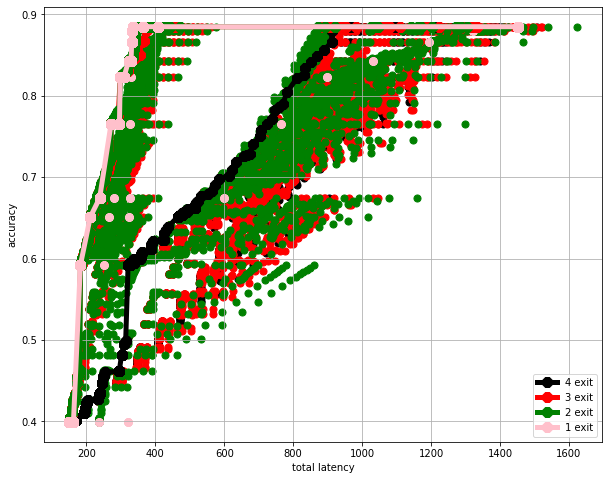

In [16]:

plt.figure(figsize=(10,8))


(x_points, y_points, _, _), (x_pareto_4tier, y_pareto_4tier, pareto_place_4tier, pareto_thresh_4tier) = pareto_frontier_finder(total_4tier, accuracy_4tier, place_4tier, threshold_4tier)
plt.scatter(x_points, y_points, s=50, color='black')
plt.plot(x_pareto_4tier, y_pareto_4tier, color='black', label='4 exit', ms=10, marker='8',linewidth=5)



(x_points, y_points, _, _), (x_pareto_3tier, y_pareto_3tier, pareto_place_3tier, pareto_thresh_3tier) = pareto_frontier_finder(total_3tier, accuracy_3tier, place_3tier, threshold_3tier)
plt.scatter(x_points, y_points, s=50, color='r')
plt.plot(x_pareto_3tier, y_pareto_3tier, color='r', label='3 exit', ms=10, marker='8',linewidth=5)



(x_points, y_points, _, _), (x_pareto_2tier, y_pareto_2tier, pareto_place_2tier, pareto_thresh_2tier) = pareto_frontier_finder(total_2tier, accuracy_2tier, place_2tier, threshold_2tier)
plt.scatter(x_points, y_points, s=50, color='g')
plt.plot(x_pareto_2tier, y_pareto_2tier, color='g', label='2 exit', ms=10, marker='8',linewidth=5)



(x_points, y_points, _, _), (x_pareto_1tier, y_pareto_1tier, pareto_place_1tier, pareto_thresh_1tier) = pareto_frontier_finder(total_1tier, accuracy_1tier,place_1tier, threshold_1tier)
plt.scatter(x_points, y_points, s=50, color='pink')
plt.plot(x_pareto_1tier, y_pareto_1tier, color='pink', label='1 exit', ms=10, marker='8',linewidth=5)



plt.grid()
plt.legend(loc='lower right')
plt.xlabel('total latency')
plt.ylabel('accuracy')
# plt.ylim(0.35, 0.9)
# plt.xlim(10,300)

plt.show()